# Task 1 — Binary Image + Structuring Element

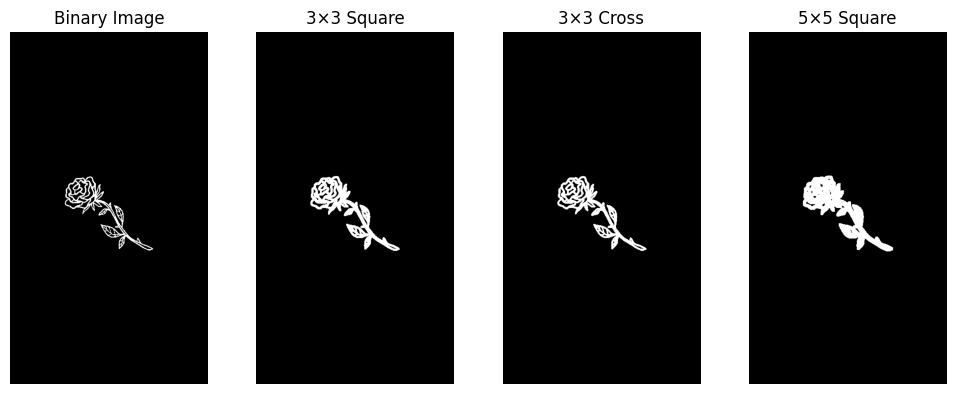

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Load grayscale image
img = cv2.imread("image1.jpeg", cv2.IMREAD_GRAYSCALE)

# 2. Convert to binary image using thresholding
_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

# 3. Create structuring elements
se_square_3 = np.ones((3, 3), np.uint8)          # 3×3 square
se_cross_3 = cv2.getStructuringElement(
    cv2.MORPH_CROSS, (3, 3))                      # 3×3 cross
se_square_5 = np.ones((5, 5), np.uint8)          # 5×5 square

# Dilation using different SEs
dil_square_3 = cv2.dilate(binary, se_square_3, iterations=1)
dil_cross_3 = cv2.dilate(binary, se_cross_3, iterations=1)
dil_square_5 = cv2.dilate(binary, se_square_5, iterations=1)

# Display results
plt.figure(figsize=(10, 4))

plt.subplot(1, 4, 1)
plt.title("Binary Image")
plt.imshow(binary, cmap="gray")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.title("3×3 Square")
plt.imshow(dil_square_3, cmap="gray")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.title("3×3 Cross")
plt.imshow(dil_cross_3, cmap="gray")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.title("5×5 Square")
plt.imshow(dil_square_5, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

# Observation:
# Square structuring elements cause uniform growth in all directions,
# while a cross-shaped SE expands objects mainly along horizontal and vertical directions.


# Task 2 — Noise Removal Without Touching the Object

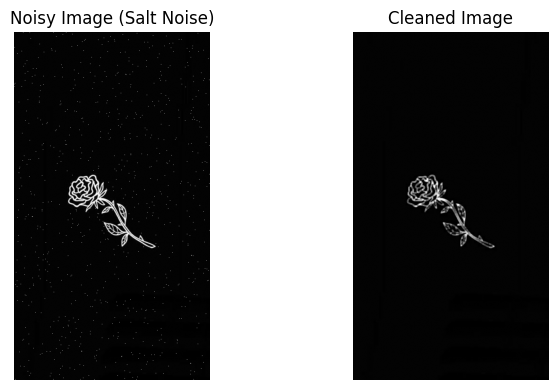

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load binary image 
binary = cv2.imread("image1.jpeg", cv2.IMREAD_GRAYSCALE)

# 1. Add salt noise
noisy = binary.copy()
num_noise_pixels = 800  
coords = [
    np.random.randint(0, noisy.shape[0], num_noise_pixels),
    np.random.randint(0, noisy.shape[1], num_noise_pixels)
]
noisy[coords[0], coords[1]] = 255

# Structuring element
se = np.ones((3, 3), np.uint8)

# 2. Remove noise using morphology only
# Opening removes small white noise
cleaned = cv2.morphologyEx(noisy, cv2.MORPH_OPEN, se)

# Display results
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Noisy Image (Salt Noise)")
plt.imshow(noisy, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Cleaned Image")
plt.imshow(cleaned, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

# Observation:
# Opening was most effective because erosion removes small isolated noise pixels,
# and dilation restores the original object shape without reintroducing noise.

# Task 3 — Fill Gaps in Broken Objects

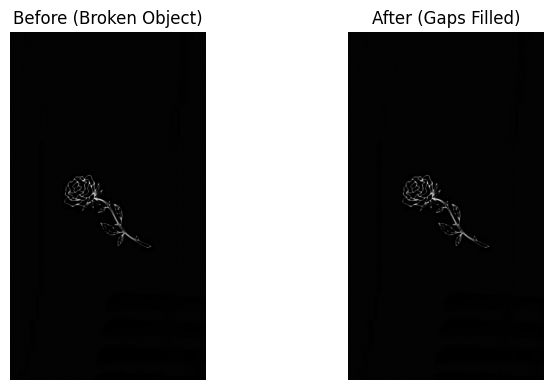

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load binary image
binary = cv2.imread("image1.jpeg", cv2.IMREAD_GRAYSCALE)

# 1. Create small breaks artificially (simulate broken object)
se_break = np.ones((3, 3), np.uint8)
broken = cv2.erode(binary, se_break, iterations=1)

# 2. Morphological closing to fill gaps
se_close = np.ones((3, 3), np.uint8)
filled = cv2.morphologyEx(broken, cv2.MORPH_CLOSE, se_close)

# Display results
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Before (Broken Object)")
plt.imshow(broken, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("After (Gaps Filled)")
plt.imshow(filled, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

# Observation:
# If the structuring element is too large, closing over-smooths the object,
# causing loss of fine details and unnatural thickening of structures.


# Task 4 — Sobel vs Canny (Edge Reality Check)

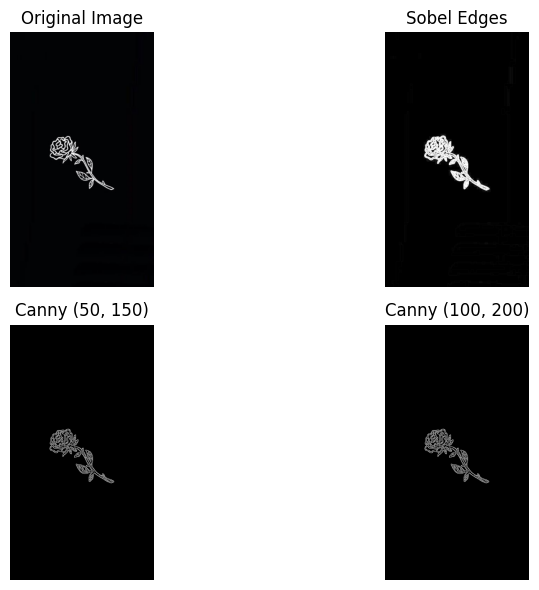

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Load natural image and convert to grayscale
img = cv2.imread("image1.jpeg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 2A. Sobel edge detection
sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
sobel = cv2.magnitude(sobel_x, sobel_y)
sobel = cv2.convertScaleAbs(sobel)

# 2B. Canny edge detection (two different threshold pairs)
canny_low = cv2.Canny(gray, 50, 150)
canny_high = cv2.Canny(gray, 100, 200)

# Display results
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(2, 2, 2)
plt.title("Sobel Edges")
plt.imshow(sobel, cmap="gray")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.title("Canny (50, 150)")
plt.imshow(canny_low, cmap="gray")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.title("Canny (100, 200)")
plt.imshow(canny_high, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

# Observation:
# As Canny thresholds increase, weak and low-contrast edges disappear first,
# while strong edges corresponding to major object boundaries remain.


# Task 5 — Line Detection from Scratch (Pipeline Thinking)

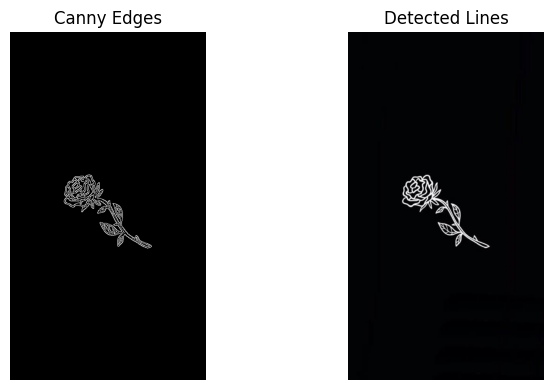

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load natural image
img = cv2.imread("image1.jpeg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 1. Canny edge detection (use the same output from Task 4)
edges = cv2.Canny(gray, 100, 200)

# 2. Hough Line Transform
lines = cv2.HoughLines(edges, 1, np.pi/180, 150)

# Copy image for drawing
line_img = img.copy()

# Draw detected lines
if lines is not None:
    for i in range(min(len(lines), 20)):  # limit lines for clarity
        rho, theta = lines[i][0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho

        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))

        cv2.line(line_img, (x1, y1), (x2, y2), (0, 0, 255), 2)

# Display results
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Canny Edges")
plt.imshow(edges, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Detected Lines")
plt.imshow(cv2.cvtColor(line_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()

# Observation:
# When the Hough threshold is too low, many spurious lines are detected,
# including lines formed from noise and fragmented edges.


# Task 6 — Fourier Transform: See the Invisible

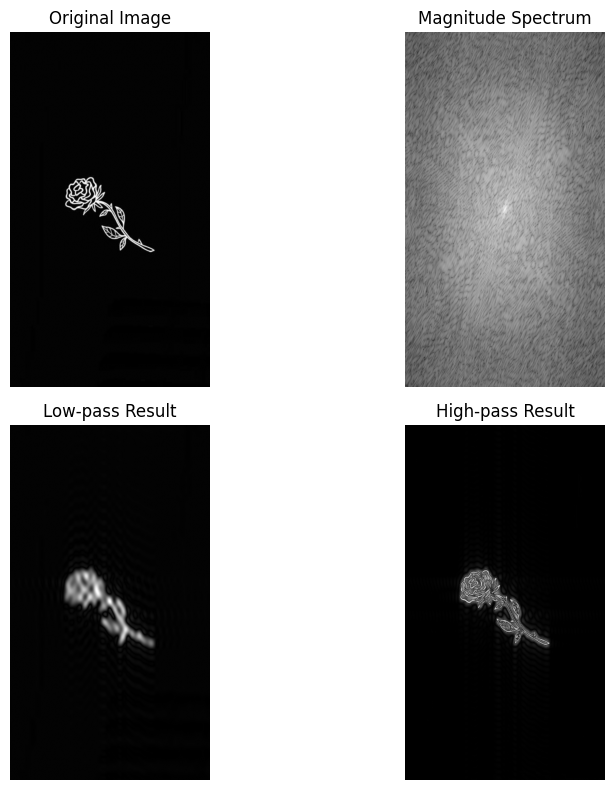

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Load grayscale image
img = cv2.imread("image1.jpeg", cv2.IMREAD_GRAYSCALE)

# 2. Compute 2D FFT
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)

# Magnitude spectrum
magnitude_spectrum = np.log(1 + np.abs(fshift))

# 3A. Low-pass filter
rows, cols = img.shape
crow, ccol = rows // 2, cols // 2

lp_mask = np.zeros((rows, cols), np.uint8)
lp_mask[crow-30:crow+30, ccol-30:ccol+30] = 1

# 3B. High-pass filter
hp_mask = np.ones((rows, cols), np.uint8)
hp_mask[crow-30:crow+30, ccol-30:ccol+30] = 0

# Apply filters
fshift_lp = fshift * lp_mask
fshift_hp = fshift * hp_mask

# 4. Inverse FFT
img_lp = np.fft.ifft2(np.fft.ifftshift(fshift_lp))
img_lp = np.abs(img_lp)

img_hp = np.fft.ifft2(np.fft.ifftshift(fshift_hp))
img_hp = np.abs(img_hp)

# Display results
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.title("Original Image")
plt.imshow(img, cmap="gray")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.title("Magnitude Spectrum")
plt.imshow(magnitude_spectrum, cmap="gray")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.title("Low-pass Result")
plt.imshow(img_lp, cmap="gray")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.title("High-pass Result")
plt.imshow(img_hp, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

# Observation:
# High-pass filtering affects edges more by preserving rapid intensity changes,
# while low-pass filtering smooths the image and suppresses edge information.


# Task 7 — Contours as Object Boundaries

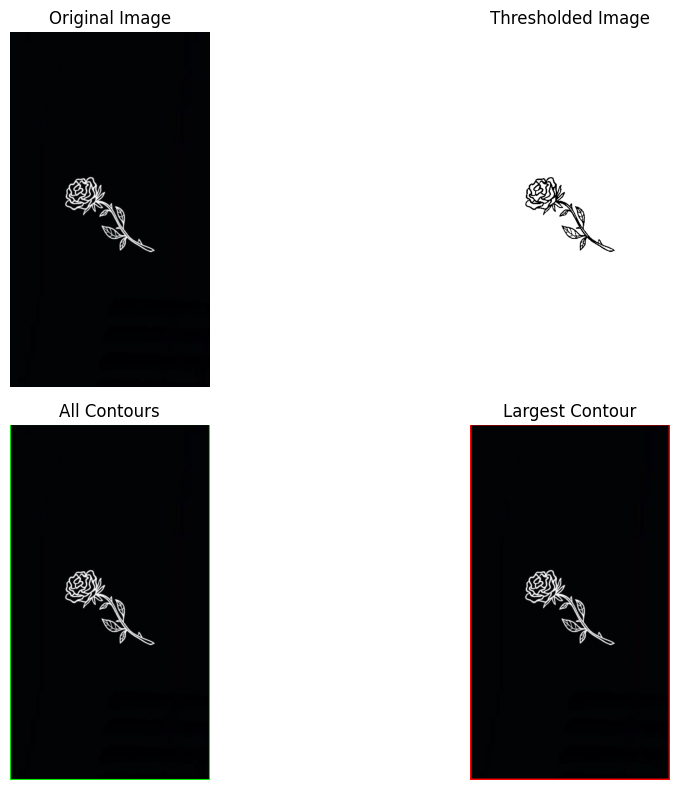

In [12]:
import cv2
import matplotlib.pyplot as plt

# 1: Read and preprocess image
img = cv2.imread("image1.jpeg")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Invert image 
gray_inv = cv2.bitwise_not(gray)

# Apply binary threshold
_, thresh = cv2.threshold(gray_inv, 127, 255, cv2.THRESH_BINARY)

# 2: Detect contours
contours, hierarchy = cv2.findContours(
    thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

# 3A: Draw all contours
img_all_contours = img.copy()
cv2.drawContours(img_all_contours, contours, -1, (0, 255, 0), 2)

# 3B: Draw largest contour only
img_largest_contour = img.copy()
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    cv2.drawContours(img_largest_contour, [largest_contour], -1, (0, 0, 255), 3)

# 4: Display results using matplotlib
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(2, 2, 2)
plt.title("Thresholded Image")
plt.imshow(thresh, cmap="gray")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.title("All Contours")
plt.imshow(cv2.cvtColor(img_all_contours, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(2, 2, 4)
plt.title("Largest Contour")
plt.imshow(cv2.cvtColor(img_largest_contour, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()

# Observation — Poor Thresholding

# If thresholding is not good:
# Contours may be broken → objects may have multiple small contours instead of one clean boundary.
# Noise appears → random small contours may appear from background pixels.
# Largest contour detection may fail → the actual object may not have the largest area if the background is incorrectly included

# Final Challenge — Combine Everything

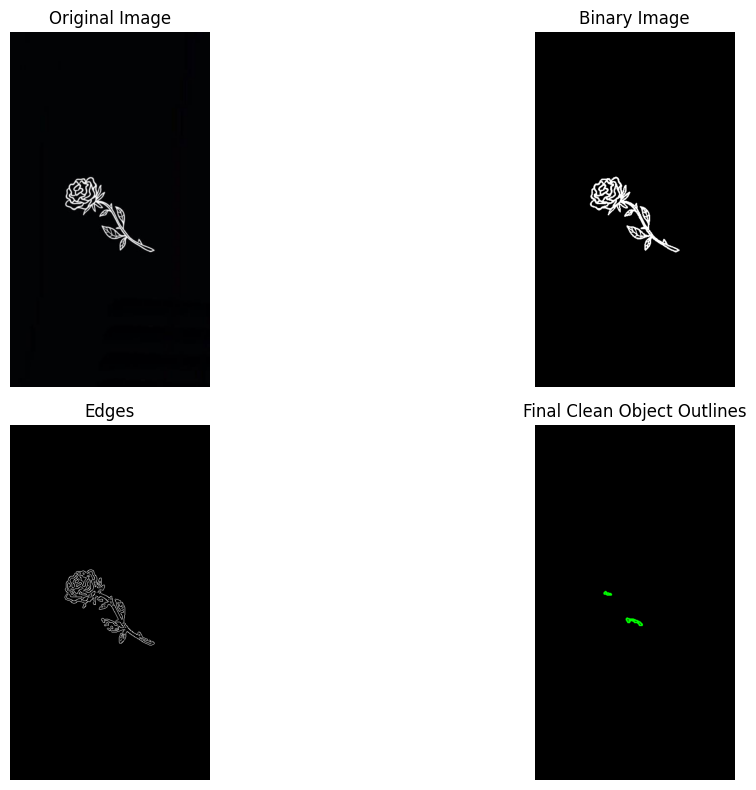

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread("image1.jpeg")

if img is None:
    print("ERROR: Image not loaded")
    exit()

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Threshold to get binary image 
_, binary = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)

# Morphology to clean very tiny noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

# Edge detection (Canny)
edges = cv2.Canny(cleaned, threshold1=30, threshold2=100)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter meaningful contours
meaningful_contours = [
    cnt for cnt in contours if cv2.contourArea(cnt) > 50
]

# Draw contours on a black background
output = np.zeros_like(img)
cv2.drawContours(output, meaningful_contours, -1, (0, 255, 0), 2)

# Display results using matplotlib
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(2, 2, 2)
plt.title("Binary Image")
plt.imshow(binary, cmap="gray")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.title("Edges")
plt.imshow(edges, cmap="gray")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.title("Final Clean Object Outlines")
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()
